# Nelder-Mead algorithm

## Domains

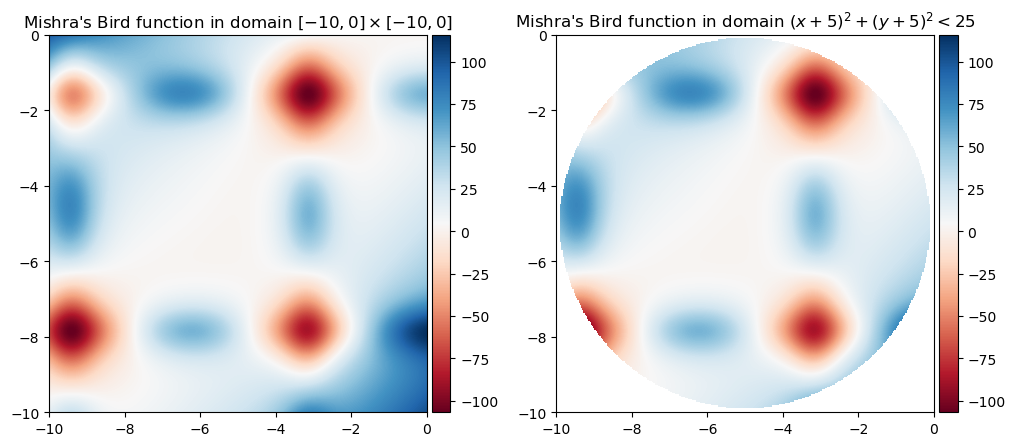

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import operator
import imageio
%matplotlib inline
        
def MB_func(point, **kw):
    
    x, y = point
    
    if kw['domain']:
        if np.power(x + 5., 2.) + np.power(y + 5., 2.) >= 25.:
            return np.nan
    
    return np.sin(y) * np.power(np.e, np.power(1 - np.cos(x), 2.)) + \
           np.cos(x) * np.power(np.e, np.power(1 - np.sin(y), 2.)) + \
           np.power(x - y, 2.)

N = 10
n = 300

x = np.linspace(-N, 0, N+n)
X = np.repeat([x], N+n, axis=0)
y = np.linspace(0, -N, N+n)
Y = np.transpose(np.repeat([y], N+n, axis=0))

f_points = np.dstack((X, Y))

Z = np.apply_along_axis(MB_func, -1, f_points, domain=False)
Z_dom = np.apply_along_axis(MB_func, -1, f_points, domain=True)

Zmax = max(np.max(Z), np.max(Z_dom[~np.isnan(Z_dom)]))
Zmin = min(np.min(Z), np.min(Z_dom[~np.isnan(Z_dom)]))

fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

im_0 = ax[0].imshow(Z, interpolation='spline36', cmap=cm.RdBu, extent=[-10, 0, -10, 0], vmin=Zmin, vmax=Zmax)
ax[0].set_title('Mishra\'s Bird function in domain ' + r'$[-10, 0] \times [-10, 0]$')
divider_0 = make_axes_locatable(ax[0])
cax_0 = divider_0.append_axes("right", size="5%", pad=0.05)
cbar_0 = plt.colorbar(im_0, cax=cax_0)
im_1 = ax[1].imshow(Z_dom, interpolation='spline36', cmap=cm.RdBu, extent=[-10, 0, -10, 0], vmin=Zmin, vmax=Zmax)
ax[1].set_title('Mishra\'s Bird function in domain ' + r'$(x+5)^2 + (y+5)^2 < 25$')
divider_1 = make_axes_locatable(ax[1])
cax_1 = divider_1.append_axes("right", size="5%", pad=0.05)
cbar_1 = plt.colorbar(im_1, cax=cax_1)
plt.show()

## Steps in algorithm

In [7]:
def order(points, function, **kw):
    
    """
    Orders points of the simplex in dependency to the values of the objective function in these points
    :param points: points of the simplex
    :param function: objective function
    :param **kw: kwargs for the function
    :return ordered_points: ordered points of the simplex
    :return ordered_of_values: values of the objective function in the ordered points of the simplex
    :return oc: number of oracle calls
    """
    
    # dictionary for the objective function {point: value}
    obj_func = {}
    # number of oracle calls (initialized)
    oc = 0
    
    # for each point in simplex
    for point in points:
        
        # put point and functiion value in dictionary
        # point in tuple, because arrays and lists are not hashable
        obj_func[tuple(point)] = function(point, **kw)
        # increment of the oracle calls number
        oc += 1
    
    # sort dictionary by value
    obj_func = sorted(obj_func.items(), key=operator.itemgetter(1))
    
    # ordered points of simplex
    ordered_points = np.array([of[0] for of in obj_func])
    # values of the objective function in the ordered points
    ordered_of_values = np.array([of[1] for of in obj_func])
    
    # if any of the values is NaN, raise an exception
    if np.any(np.isnan(ordered_of_values)):
        raise Exception('NaN values in simplex')
    
    return ordered_points, ordered_of_values, oc
    
def centroid(ordered_points):
    
    """
    Calculates centroid of the n best points in the (n+1)-simplex
    :param ordered_points: points of the simplex, ordered from best to worst
    :return: centroid of n best points
    """
    
    # n best points in the (n+1)-simplex
    points = ordered_points[:-1]
    
    # x_0 = mean(points)
    center = np.sum(points, axis=0) / points.shape[0]
    
    return center

def reflection(worst_point, center, alpha):
    
    """
    Reflects worst point of the simplex over the centroid of the remaining points
    :param worst_point: worst point of the simplex to be reflected
    :param center: centroid of the remaining points
    :param alpha: coefficient of the expansion (alpha > 0)
    :return: reflected worst point
    """
    
    # if the reflection coefficient is negative, raise an exception (point doesn't overlap over centroid)
    if alpha <= 0.:
        raise Exception('Reflection coefficient is negative: {}'.format(alpha))
    
    # x_reflected = -alpha * x_worst + (1 + alpha) * x_0
    reflected_point = center + alpha * (center - worst_point)
    
    return reflected_point

def expansion(reflected_point, center, gamma):
    
    """
    Expands reflected worst point from the centroid of the remaining points in simplex
    :param reflected_point: reflected worst point of the simplex to be expanded
    :param center: centroid of the remaining points
    :param gamma: coefficient of the expansion (gamma > 1)
    :return: expanded and reflected worst point
    """
    
    # if the expansion coefficient is less than 1, raise an exception (contraction of the reflected point towards centroid)
    if gamma <= 1.:
        raise Exception('Expansion coefficient is invalid (gamma > 1.0): {}'.format(gamma))
    
    # x_expanded = gamma * x_reflected + (1 - gamma) * x_0
    expanded_point = center + gamma * (reflected_point - center)
    
    return expanded_point

def contraction(worst_point, center, beta):
    
    """
    Contracts worst point of the simplex closer to the centroid of the remaining points
    :param worst_point: worst point of the simplex to be contracted
    :param center: centroid of the remaining points
    :param beta: coefficient of the contraction (0 < beta <= 0.5)
    :return: contracted worst point
    """
    
    # if the contraction coefficient is negative, raise an exception (overlaps over centroid)
    # if the contraction coefficient is greater than 0.5, raise an exception (insufficient contraction)
    if (beta <= 0.) or (beta > 0.5):
        raise Exception('Reflection coefficient is invalid (0.0 < beta <= 0.5): {}'.format(beta))
    
    # x_contracted = beta * x_worst + (1 - beta) * x_0
    contracted_point = center + beta * (worst_point - center)
    
    return contracted_point

def shrinkage(ordered_points, sigma):
    
    """
    Shrinks simplex to the best point
    :param ordered_points: points of the simplex, ordered from best to worst
    :param sigma: coefficient of the shrinkage (0 < sigma < 1)
    :return: shrinked simplex
    """
    
    # if the shrink coefficient is negative, raise an exception (extension instead of shrinkage)
    # if the shrink coefficient is greater than 1, raise an exception (overlaps over best point)
    if (sigma <= 0.) or (sigma >= 1.):
        raise Exception('Shrink coefficient is invalid (0.0 < sigma <= 1.0): {}'.format(sigma))
    
    # array for shrinked simplex
    shrinked_points = np.copy(ordered_points)
    
    # for each point in simplex, except for the best one
    for (i, point) in enumerate(ordered_points[1:]):
        
        # x_shrinked = sigma * x + (1 - sigma) * x_best
        shrinked_points[i+1] = ordered_points[0] + sigma * (point - ordered_points[0])
        
    return shrinked_points

def terminate(points, eps_s, eps_a):
    
    """
    Calculates sides of the simplex and checks if any of them is smaller than the limit.
    If sides are smaller, the algorithm is terminated.
    If the simplex degenerates (few vertices on the same axis) the exception is raised
    :param points: vertices of the simplex
    :param eps_s: simplex side limit
    :param eps_a: limit of the parallelogram area, stretched on every two sides of the simplex
    :return: boolean variable, which states whether the algorithm should be terminated
    """
    
    def roll_cut(arr, dims, roll_num):
        
        """
        Util function, which cuts the given array in dependency to the number of the rolling points
        :param arr: given array
        :param dims: number of the rolling points
        :param roll_num: number of rolls
        """
        
        # if there are overlays in rolling combinations
        if (dims % 2 == 0):
            # cut the first and last overlayed elements
            new_arr = arr[1:-roll_num]
        # if there are none
        else:
            # cut only first element
            new_arr = arr[1:]
            
        return new_arr
    
    # number of points in simplex
    dims = points.shape[0]
    
    # if there are less than 3 points, the Nelder-Mead algorithm is unfit
    if dims < 3:
        raise Exception('Invalid amount of points in simplex: {}'.format(dims))
    
    # number of rolls, necessary to compute the vectors of simplex sides
    roll_num = int(dims / 2)
    
    # array of simplex sides vectors to be filled
    vecs = np.zeros((1, dims - 1))
    
    # after each roll
    for i in range(roll_num):
        # comute vectors and add them to the array
        # A   B    C    D
        # D   A    B    C
        # C   D    A    B
        # ----------------
        # AD  BA   CB   DC
        # AC  BD  {CA} {DB}
        vecs = np.vstack((vecs, points - np.roll(points, i+1, axis=0)))
    
    # in dependency to the number of points (even), cut repeating vectors ({CA} and {DB} in example above)
    vecs = roll_cut(vecs, dims, roll_num)
    
    # sides of the simplex
    norms = np.linalg.norm(vecs, axis=1)
    
    # number of vectors
    vec_dims = vecs.shape[0]
    # number of rolls, necessary to compute the vectors dot products (and areas between them)
    vec_roll_num = int(vec_dims / 2)
    
    # array of areas between each couple of vectors to be filled
    areas = np.zeros((1, ))
    
    # after each vectors' roll (same procedure as for points rolling)
    for i in range(vec_roll_num):
        
        # vectors' roll
        rolled_vecs = np.roll(vecs, i+1, axis=0)
        # dot products of different vectors squared <x,y>^2
        dot_prod_sqr = np.einsum('ij,ij->i', vecs, rolled_vecs)**2
        # norms of x vecor squared |x|^2
        vec_norm_sqr = np.einsum('ij,ij->i', vecs, vecs)
        # norms of y vecor squared |y|^2
        rolled_vec_norm_sqr = np.einsum('ij,ij->i', rolled_vecs, rolled_vecs)
        
        # areas of parallelograms, streched onto the vectors x and y (S^2 = |x|^2|y|^2 - <x,y>^2)
        area = np.sqrt(vec_norm_sqr * rolled_vec_norm_sqr - dot_prod_sqr)
        
        # add areas to the array
        areas = np.hstack((areas, area))
    
    # in dependency to the number of vectors (even), cut repeating areas
    areas = roll_cut(areas, vec_dims, vec_roll_num)
    
    # if any area between vectors is coming to 0.0, while sides of simplex remain big,
    # the simplex is considered to be degenerated (example: few points on the same axis)
    if np.any(areas < eps_a) and np.any(norms > eps_s):
        raise Exception('Degenerated simplex, |x|^2|y|^2 - <x,y>^2 = {}^2'.format(np.min(areas)))
    
    # if all sides of the simplex are smaller than the given limit, the algorithm is terminated
    term_condition = np.all(norms < eps_s)
    
    return term_condition

## The Algorithm

In [8]:
def nelder_mead_algorithm(init_simplex, function, eps_s, eps_a, alpha, beta, gamma, sigma, **kw):
    
    """
    Implements Nelder-Mead algorithm for given function
    :param init_simplex: initial simplex of the algorithm
    :param function: objective function of the algorithm
    :param eps_s: simplex sides length tolerance
    :param eps_a: minimal area between simpex sides (if smaller -- simplex degenerated)
    :param alpha: coefficient of the expansion (alpha > 0)
    :param beta: coefficient of the contraction (0 < beta <= 0.5)
    :param gamma: coefficient of the expansion (gamma > 1)
    :param sigma: coefficient of the shrinkage (0 < sigma < 1)
    :param **kw: kwargs for the given function
    :return x_min: point of minimum of the objective function
    :return simplexes: array of intermidiate simplexes
    :return phases: list of actions to move every simplex
    :return oc: number of oracle calls
    :return iters: number of iterations
    """
    
    # number of oracle calls (initialized)
    oc = 0
    # number of iterations (initialized as -1 to compensate for the initial simplex)
    iters = -1
    
    # current simplex
    points = np.copy(init_simplex)
    
    # array of simplexes
    simplexes = np.zeros_like(init_simplex)
    
    # list of phases
    phases = ['Initial simplex']
    
    while(True):
    
        ordered_points, f, oc_acc = order(points, function, **kw)
        
        oc += oc_acc
        
        simplexes = np.vstack((simplexes, ordered_points))
        iters += 1
        
        if terminate(ordered_points, eps_s, eps_a):
            break

        x_0 = centroid(ordered_points)

        worst_point = ordered_points[-1]
        
        f_r = np.nan
        r_flag = 1.
        
        while (np.isnan(f_r)):
            
            x_r = reflection(worst_point, x_0, alpha / r_flag)

            f_r = function(x_r, **kw)
            
            oc += 1
            
            r_flag *= 2.
            
            if (r_flag > 1000):
                
                raise Exception('Can\'t reflect to the point of NaN (out of domain)')

        if (f_r < f[-2]) and (f_r >= f[0]):
            
            phases.append('Reflection')

            ordered_points[-1] = x_r
            points = ordered_points

        elif (f_r < f[0]):
            
            f_e = np.nan
            e_flag = 1.
            
            while(np.isnan(f_e)):
            
                x_e = expansion(x_r, x_0, (gamma + e_flag - 1.) / e_flag)
                
                f_e = function(x_e, **kw)
                
                oc += 1
                
                e_flag *= 2.
                
                if (e_flag > 1000):
                    
                    raise Exception('Can\'t expand to the point of NaN (out of domain)')

            if (f_e < f_r):

                phases.append('Expansion')

                ordered_points[-1] = x_e
                points = ordered_points

            else:

                phases.append('Reflection')

                ordered_points[-1] = x_r
                points = ordered_points

        else:

            x_c = contraction(worst_point, x_0, beta)

            f_c = function(x_c, **kw)
            
            oc += 1

            if (f_c < f[-1]):

                phases.append('Contraction')

                ordered_points[-1] = x_c
                points = ordered_points

            else:

                phases.append('Shrinkage')

                points = shrinkage(ordered_points, sigma)
    
    simplexes = simplexes[points.shape[0]:]
    sim_num = int(simplexes.shape[0] / points.shape[0])
    simplexes = simplexes.reshape(sim_num, int(points.shape[0]), int(points.shape[1]))
    
    return ordered_points[0], simplexes, phases, oc, iters

## Function to show all steps of algorithm in one picture

In [9]:
def pic_nelder_mead(p_in_ax, init_simplex, function, eps_s, eps_a, alpha, beta, gamma, sigma, **kw):
    
    x_min, simplexes, phases, oc, iters = nelder_mead_algorithm(init_simplex, function,
                                                                eps_s, eps_a, alpha, beta, gamma, sigma, **kw)
    
    print('x_min: {}'.format(x_min))
    print('Oracle calls: {}'.format(oc))
    print('Iterations: {}'.format(iters))
    
    N = 10

    x = np.linspace(-N, 0, N+p_in_ax)
    X = np.repeat([x], N+p_in_ax, axis=0)
    y = np.linspace(0, -N, N+p_in_ax)
    Y = np.transpose(np.repeat([y], N+p_in_ax, axis=0))

    f_points = np.dstack((X, Y))

    Z = np.apply_along_axis(function, -1, f_points, **kw)
    
    if kw['domain']:
        dom_str = r'$(x+5)^2 + (y+5)^2 < 25$'
    else:
        dom_str = r'$[-10, 0] \times [-10, 0]$'
        
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    plt.suptitle('Nelder-Mead on Mishra\'s Bird function in domain ' + r'{0}'.format(dom_str) + '\n' + \
                 r'$\alpha = {0}$, $\beta = {1}$, $\gamma = {2}$, $\sigma = {3}$'
                 .format(alpha, beta, gamma, sigma), fontsize=15)

    im = ax.imshow(Z, interpolation='spline36', cmap=cm.RdBu, extent=[-10, 0, -10, 0])

    for sim in simplexes:

        x_s, y_s = np.transpose(sim)
        ax.scatter(x_s, y_s, color='g')

        r_sim = np.dstack((sim, np.roll(sim, 1, axis=0)))
        r_sim[1:] = np.flip(r_sim[1:], 2)

        for points_c in r_sim:

            x_c, y_c = points_c

            ax.plot(x_c, y_c, color='g')

    ax.set_title('All sets', fontsize=14)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    plt.show()

## Function to create the GIF of working algorithm

In [10]:
def gif_nelder_mead(p_in_ax, init_simplex, function, eps_s, eps_a, alpha, beta, gamma, sigma, filename, **kw):
    
    x_min, simplexes, phases, oc, iters = nelder_mead_algorithm(init_simplex, function,
                                                                eps_s, eps_a, alpha, beta, gamma, sigma, **kw)
    
    N = 10

    x = np.linspace(-N, 0, N+p_in_ax)
    X = np.repeat([x], N+p_in_ax, axis=0)
    y = np.linspace(0, -N, N+p_in_ax)
    Y = np.transpose(np.repeat([y], N+p_in_ax, axis=0))

    f_points = np.dstack((X, Y))

    Z = np.apply_along_axis(function, -1, f_points, **kw)
    
    if kw['domain']:
        dom_str = r'$(x+5)^2 + (y+5)^2 < 25$'
    else:
        dom_str = r'$[-10, 0] \times [-10, 0]$'

    images = []

    for (sim, phase) in zip(simplexes, phases):

        fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=100)

        plt.suptitle('Nelder-Mead on Mishra\'s Bird function in domain ' + r'{0}'.format(dom_str) + '\n' + \
                 r'$\alpha = {0}$, $\beta = {1}$, $\gamma = {2}$, $\sigma = {3}$'
                 .format(alpha, beta, gamma, sigma), fontsize=15)

        im = ax.imshow(Z, interpolation='spline36', cmap=cm.RdBu, extent=[-10, 0, -10, 0])

        x_s, y_s = np.transpose(sim)
        ax.scatter(x_s, y_s, color='black')

        r_sim = np.dstack((sim, np.roll(sim, 1, axis=0)))
        r_sim[1:] = np.flip(r_sim[1:], 2)

        for points_c in r_sim:

            x_c, y_c = points_c

            ax.plot(x_c, y_c, color='black')

        ax.set_title(phase, fontsize=10)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax)

        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        images.append(image)
        
        plt.close()
        
    imageio.mimsave('./{0}.gif'
                    .format(filename), images, fps=1)

## Testing algorithm for round domain

x_min: [-9.18545344 -7.73360378]
Oracle calls: 112
Iterations: 18


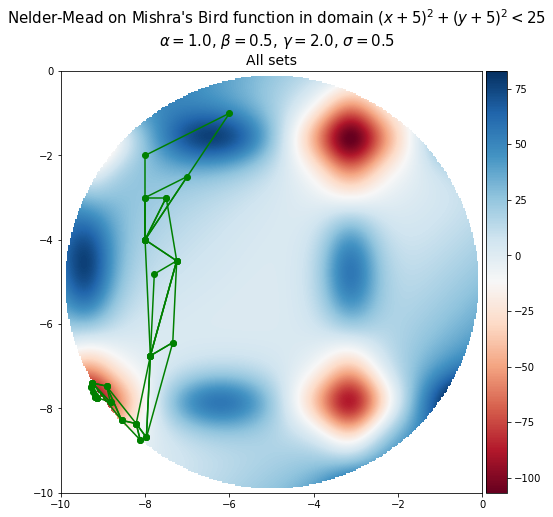

In [43]:
P_IN_AX = 300
INIT_SIMPLEX = np.array([[-8., -4.], [-6., -1.], [-8., -2.]])
FUNCTION = MB_func
EPS_S = 0.1
EPS_A = 1e-10
ALPHA = 1.
BETA = 0.5
GAMMA = 2.
SIGMA = 0.5
DOMAIN = True

pic_nelder_mead(P_IN_AX, INIT_SIMPLEX, FUNCTION, EPS_S, EPS_A, ALPHA, BETA, GAMMA, SIGMA, domain=DOMAIN)

In [35]:
P_IN_AX = 300
INIT_SIMPLEX = np.array([[-8., -4.], [-6., -1.], [-8., -2.]])
FUNCTION = MB_func
EPS_S = 0.1
EPS_A = 1e-10
ALPHA = 1.
BETA = 0.5
GAMMA = 2.
SIGMA = 0.5
DOMAIN = True

FILENAME = 'RoundDomain'

gif_nelder_mead(P_IN_AX, INIT_SIMPLEX, FUNCTION, EPS_S, EPS_A, ALPHA, BETA, GAMMA, SIGMA, FILENAME, domain=DOMAIN)

![](RoundDomain.gif)

## Algorithm for square domain

### Case №1

x_min: [-3.13362765 -1.56029344]
Oracle calls: 85
Iterations: 17


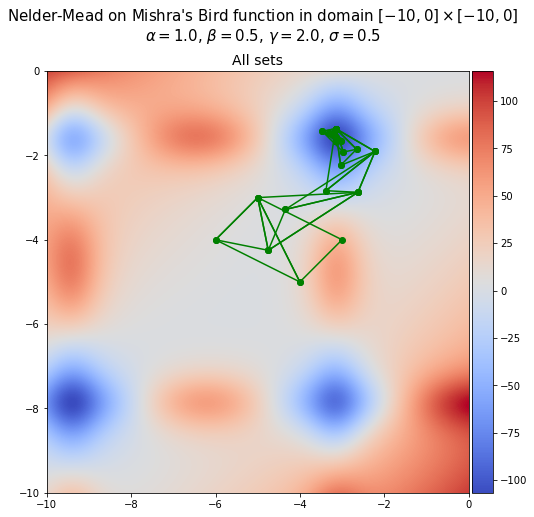

In [36]:
P_IN_AX = 300
INIT_SIMPLEX = np.array([[-3., -4.], [-4., -5.], [-5., -3.]])
FUNCTION = MB_func
EPS_S = 0.1
EPS_A = 1e-10
ALPHA = 1.
BETA = 0.5
GAMMA = 2.
SIGMA = 0.5
DOMAIN = False

pic_nelder_mead(P_IN_AX, INIT_SIMPLEX, FUNCTION, EPS_S, EPS_A, ALPHA, BETA, GAMMA, SIGMA, domain=DOMAIN)

In [44]:
P_IN_AX = 300
INIT_SIMPLEX = np.array([[-3., -4.], [-4., -5.], [-5., -3.]])
FUNCTION = MB_func
EPS_S = 0.1
EPS_A = 1e-10
ALPHA = 1.
BETA = 0.5
GAMMA = 2.
SIGMA = 0.5
DOMAIN = False

FILENAME = 'SquareDomain1'

gif_nelder_mead(P_IN_AX, INIT_SIMPLEX, FUNCTION, EPS_S, EPS_A, ALPHA, BETA, GAMMA, SIGMA, FILENAME, domain=DOMAIN)

![](SquareDomain1.gif)

### Case №2. Different initial simplex

x_min: [-3.16537476 -7.78179932]
Oracle calls: 85
Iterations: 17


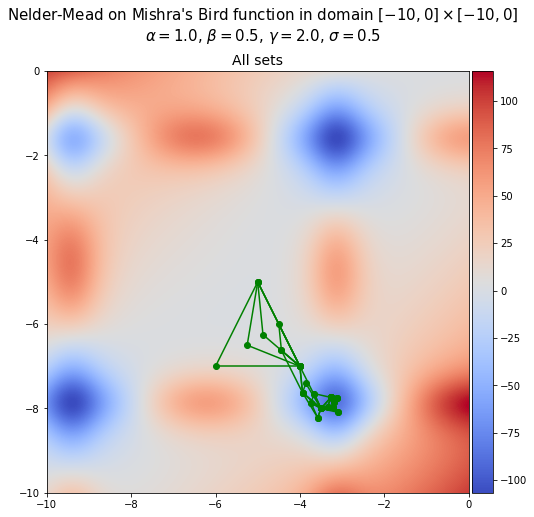

In [ ]:
P_IN_AX = 300
INIT_SIMPLEX = np.array([[-4., -7.], [-6., -7.], [-5., -5.]])
FUNCTION = MB_func
EPS_S = 0.1
EPS_A = 1e-10
ALPHA = 1.
BETA = 0.5
GAMMA = 2.
SIGMA = 0.5
DOMAIN = False

pic_nelder_mead(P_IN_AX, INIT_SIMPLEX, FUNCTION, EPS_S, EPS_A, ALPHA, BETA, GAMMA, SIGMA, domain=DOMAIN)

In [ ]:
P_IN_AX = 300
INIT_SIMPLEX = np.array([[-4., -7.], [-6., -7.], [-5., -5.]])
FUNCTION = MB_func
EPS_S = 0.1
EPS_A = 1e-10
ALPHA = 1.
BETA = 0.5
GAMMA = 2.
SIGMA = 0.5
DOMAIN = False

FILENAME = 'SquareDomain2'

gif_nelder_mead(P_IN_AX, INIT_SIMPLEX, FUNCTION, EPS_S, EPS_A, ALPHA, BETA, GAMMA, SIGMA, FILENAME, domain=DOMAIN)

![](SquareDomain2.gif)

### Case №3. Same initial simplex, but different parameters

x_min: [-3.01732969 -7.28437313]
Oracle calls: 62
Iterations: 12


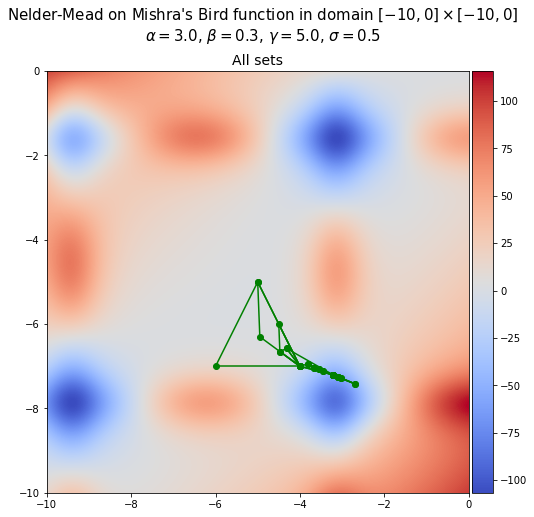

In [ ]:
P_IN_AX = 300
INIT_SIMPLEX = np.array([[-4., -7.], [-6., -7.], [-5., -5.]])
FUNCTION = MB_func
EPS_S = 0.1
EPS_A = 1e-10
ALPHA = 3.
BETA = 0.3
GAMMA = 5.
SIGMA = 0.5
DOMAIN = False

pic_nelder_mead(P_IN_AX, INIT_SIMPLEX, FUNCTION, EPS_S, EPS_A, ALPHA, BETA, GAMMA, SIGMA, domain=DOMAIN)

In [ ]:
P_IN_AX = 300
INIT_SIMPLEX = np.array([[-4., -7.], [-6., -7.], [-5., -5.]])
FUNCTION = MB_func
EPS_S = 0.1
EPS_A = 1e-10
ALPHA = 3.
BETA = 0.3
GAMMA = 5.
SIGMA = 0.5
DOMAIN = False

FILENAME = 'SquareDomain3'

gif_nelder_mead(P_IN_AX, INIT_SIMPLEX, FUNCTION, EPS_S, EPS_A, ALPHA, BETA, GAMMA, SIGMA, FILENAME, domain=DOMAIN)

![](SquareDomain3.gif)